Source: 
https://machinelearningmastery.com/inpainting-and-outpainting-with-diffusers/
https://www.freecodecamp.org/news/use-segment-anything-model-to-create-masks/

In [15]:
import numpy as np
import torch
import cv2
from PIL import Image
#import cv2.imshow
 
!pip install 'git+https://github.com/facebookresearch/segment-anything.git'
from segment_anything import sam_model_registry, SamPredictor
 
!pip install diffusers accelerate
from diffusers import StableDiffusionInpaintPipeline
 
!wget -q -nc https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
CHECKPOINT_PATH='sam_vit_b_01ec64.pth'
 
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_b"

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-icpee_hh
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-icpee_hh
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done


/home/nvidia/jupyter/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
import os
HOME = os.getcwd()
NVIDIA_PERSONAL_API_KEY = "<YOUR KEY>"
NVAI_URL_GD = "https://ai.api.nvidia.com/v1/cv/nvidia/nv-grounding-dino"

SAM_CHECKPOINT_PATH = os.path.join(HOME, "sam_vit_b_01ec64.pth")
print(HOME)

/home/nvidia/jupyter/Experiment3


## Function definition: Determine bounding box 
Notes:
* Use Grounding DINO from NVCF
* Important the bbox is NOT in the format of x1,y1,x2,y2 but (x1, y1, w, h) 

In [37]:
def delete_folder(folder):
    import os
    import shutil
    # Specify the folder to delete
    folder_path = folder

    # Check if the folder exists and delete it
    if os.path.exists(folder_path) and os.path.isdir(folder_path):
        shutil.rmtree(folder_path)
        print(f"Folder '{folder_path}' has been deleted.")
    else:
        print(f"Folder '{folder_path}' does not exist.")

    return True
    
def get_bounding_box(image_path, prompt):
    import base64
    import json
    import requests
    import zipfile
    import os
    header_auth = f"Bearer {NVIDIA_PERSONAL_API_KEY}"
    filepath = image_path
    
    with open(filepath, "rb") as f:
        image_b64 = base64.b64encode(f.read()).decode()
    
    inputs = {
        "model": "Grounding-Dino",
        "messages": [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                    {"type": "media_url", "media_url": {"url": f"data:image/jpeg;base64,{image_b64}"}}
                ]
            }
        ],
        "threshold": 0.3,
    }
    #print(inputs)
    headers = {"Content-Type": "application/json", "Authorization": header_auth}
    
    response = requests.post(NVAI_URL_GD, headers=headers, json=inputs)
    
    # Save ZIP file if Content-Type is application/zip
    if response.headers.get("Content-Type") == "application/zip":
        zip_path = "response.zip"
        with open(zip_path, "wb") as f:
            f.write(response.content)
        #print(f"ZIP file saved as '{zip_path}'")
    
        # Extract the ZIP file
        extract_to = "extracted_content"
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        #print(f"ZIP file extracted to '{extract_to}'")
    
        # List the extracted files
        files = os.listdir(extract_to)
        #print("Extracted Files:", files)
        # Load the file with the .response extension and load it 
        import json
    
        # Path to the file
        for file in os.listdir(extract_to):
            if file.endswith(".response"):
                response_file = os.path.join(extract_to, file)
                break
        
        file_path = response_file
        
        # Open and read the JSON file
        with open(file_path, "r") as file:
            data = json.load(file)
        
            # Extract the bounding boxes
            bboxes = []
          
            if "choices" in data and data["choices"]:
                for choice in data["choices"]:
                    if "message" in choice and "content" in choice["message"]:
                        content = choice["message"]["content"]
                        if "boundingBoxes" in content:
                            content = content['boundingBoxes']
                            #print("%" * 10)
                            #print(content)
                            if "bboxes" in content[0]:
                                content = content[0]['bboxes']
                                #print("$" * 10)
                                #print(content)
                                for box in content:
                                    #print(box)
                                    #print("-"*10)
                                    x1,y1,w,h = box
                                    x2 = x1 + w
                                    y2 = y1 + h
                                    
                                    box = [x1, y1, x2, y2]
                                    #print(box)
                                    bboxes.append(box)
                                    
                                delete_folder("extracted_content")
                                return bboxes
    
    
    else:
        print("Unexpected Content-Type:", response.headers.get("Content-Type"))
        print("Raw Response:", repr(response.content))
        return None


## Function definition: Generate a regular shaped mask
Notes:
* To be used with the output of the Grounding DINO bounding box

In [18]:
def generate_regular_mask(image_path, output_path, bounding_boxes):
    import numpy as np
    import cv2
    from PIL import Image
    
    # Image dimensions
    image = cv2.imread(image_path)
    
    # Get height and width
    image_height, image_width = image.shape[:2]
    
    print(f"Image Width: {image_width}, Image Height: {image_height}")
    
    # Example bounding boxes (replace with your actual bounding boxes)
    # Format: [[x_min, y_min, x_max, y_max], ...]
    bounding_boxes = np.array(bounding_boxes)
    # Create an empty binary mask (initialized to 0)
    mask = np.zeros((image_height, image_width), dtype=np.uint8)
    
    # Iterate through bounding boxes and fill the mask
    for box in bounding_boxes:
        x_min, y_min, x_max, y_max = box
        mask[y_min:y_max, x_min:x_max] = 255  # Set the region inside the bounding box to 255 (white)
    
    # Save the mask or visualize it
    cv2.imwrite(output_path, mask)
    return mask
# Optional: Visualize the mask
#Image.fromarray(mask).show()

In [62]:
def generate_regular_extended_mask(image_path, output_path, bounding_boxes):
    import numpy as np
    import cv2
    from PIL import Image
    
    # Image dimensions
    image = cv2.imread(image_path)
    
    # Get height and width
    image_height, image_width = image.shape[:2]
    
    print(f"Image Width: {image_width}, Image Height: {image_height}")
    
    # Convert bounding boxes to numpy array
    bounding_boxes = np.array(bounding_boxes)
    
    # Create an empty binary mask (initialized to 0)
    mask = np.zeros((image_height, image_width), dtype=np.uint8)
    
    # Iterate through bounding boxes and expand them
    for box in bounding_boxes:
        x_min, y_min, x_max, y_max = box
        
        # Calculate 5% expansion margin
        margin_x = int((x_max - x_min) * 0.02)
        margin_y = int((y_max - y_min) * 0.02)
        
        # Apply margin while ensuring boundaries stay within the image dimensions
        expanded_x_min = max(x_min - margin_x, 0)
        expanded_y_min = max(y_min - margin_y, 0)
        expanded_x_max = min(x_max + margin_x, image_width)
        expanded_y_max = min(y_max + margin_y, image_height)
        
        # Update the mask with the expanded bounding box
        mask[expanded_y_min:expanded_y_max, expanded_x_min:expanded_x_max] = 255  # Set to 255 (white)
    
    # Save the mask or visualize it
    cv2.imwrite(output_path, mask)
    return mask
# Optional: Visualize the mask
# Image.fromarray(mask).show()


## Function definition: Use Segment Anything to generate the mask

In [23]:
def generate_sam_mask(image_path, output_path, bounding_boxes):
    print(SAM_CHECKPOINT_PATH)
    
    import torch
    import numpy as np
    import cv2
    from segment_anything import SamPredictor, sam_model_registry
    
    # Load image
    image = Image.open(image_path).convert("RGB")
    image_np = np.array(image)  # Convert to numpy array if needed for visualization
    
    # Initialize the SAM
    sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH)
    
    # Initialize the SAM predictor
    sam_predictor = SamPredictor(sam)
    
    # Convert image for the SAM model and set the image
    sam_predictor.set_image(image_np)
    
    # Example bounding box (update with your actual bounding box values)
    # Format: [x_min, y_min, x_max, y_max]
    bounding_boxes = np.array(bounding_boxes)  # Replace with actual bounding box coordinates
    
    # Generate the mask
    masks, scores, logits = sam_predictor.predict(
        point_coords=None,  # No specific points
        point_labels=None,  # No specific point labels
        box=bounding_boxes[0],  # Use the first bounding box
        mask_input=None,  # No mask input
        multimask_output=False  # Set to True if you want multiple masks
    )
    
    # Output results
    print("Masks shape:", masks.shape)
    print("Scores:", scores)
    
    # Optional: Save or visualize the mask
    # Converting the mask to a displayable image
    mask_image = (masks[0] * 255).astype(np.uint8)
    cv2.imwrite(output_path, mask_image)  # Save mask
    return mask_image

## Experiment 1 - Use Simple lama to inpaint with the masks created.

In [30]:
def inpaint_simplelama(image_path, output_path, mask_path):
    import torch
    from simple_lama_inpainting import SimpleLama
    from PIL import Image
    
    # Specify the image and mask paths
    simple_lama = SimpleLama()
    image = Image.open(image_path)
    mask = Image.open(mask_path).convert('L')  
    
    result = simple_lama(image, mask)
    result.save(output_path)
    return True

In [40]:
def plot_images(image_paths):
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg    
    # Create a horizontal layout with 5 subplots
    fig, axes = plt.subplots(1, 5, figsize=(20, 5))  # 1 row, 5 columns
    
    # Iterate over image paths and axes
    for ax, image_path in zip(axes, image_paths):
        image = mpimg.imread(image_path)
        ax.imshow(image)
        ax.axis('off')  # Turn off the axis for clean display
    
    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

### Image 1 
Create the masks and the outputs 
Plot the results

Folder 'extracted_content' has been deleted.
[[0, 103, 124, 205]]
Image Width: 194, Image Height: 259
/home/nvidia/jupyter/Experiment3/sam_vit_b_01ec64.pth
Masks shape: (1, 259, 194)
Scores: [0.98318636]
Image Width: 194, Image Height: 259


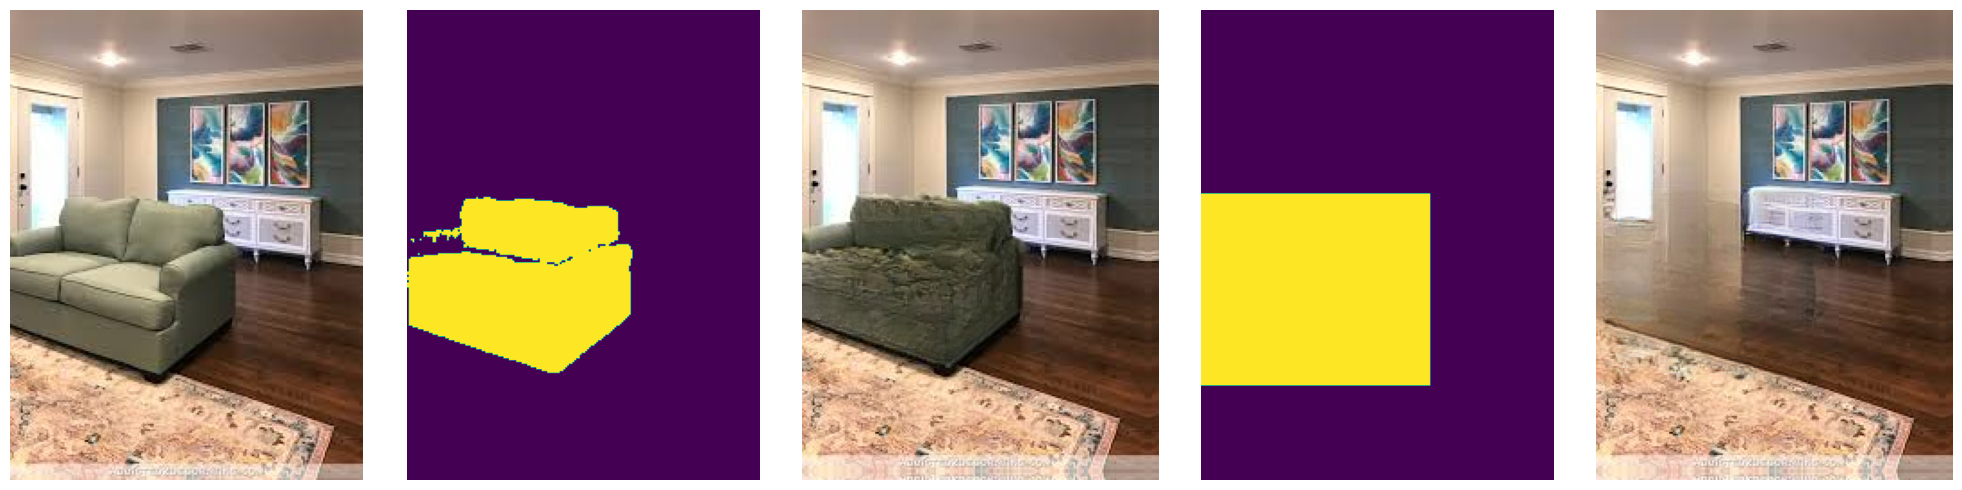

In [63]:
IMAGE_PATH = "input/image1.png"
OUTPUT_SAM_MASK = "output/image1_sam_mask.png"
OUTPUT_GD_MASK = "output/image1_gd_mask.png"
OUTPUT_GD_EXTENDED_MASK = "output/image1_gd_extended_mask.png"

OUTPUT_SAM_SIMPLE_LAMA = "output/image1_sam_simple_lama.png"
OUTPUT_GD_SIMPLE_LAMA = "output/image1_gd_simple_lama.png"
OUTPUT_GD_EXTENDED_SIMPLE_LAMA = "output/image1_gd_extended_simple_lama.png"

bounding_boxes = get_bounding_box(IMAGE_PATH, "sofa")
print(bounding_boxes)
generate_regular_mask(IMAGE_PATH, OUTPUT_GD_MASK, bounding_boxes)
generate_sam_mask(IMAGE_PATH, OUTPUT_SAM_MASK, bounding_boxes)

generate_regular_extended_mask(IMAGE_PATH, OUTPUT_GD_EXTENDED_MASK, bounding_boxes)

inpaint_simplelama(IMAGE_PATH, OUTPUT_SAM_SIMPLE_LAMA, OUTPUT_SAM_MASK)
inpaint_simplelama(IMAGE_PATH, OUTPUT_GD_SIMPLE_LAMA, OUTPUT_GD_MASK)
inpaint_simplelama(IMAGE_PATH, OUTPUT_GD_EXTENDED_SIMPLE_LAMA, OUTPUT_GD_EXTENDED_MASK)

images_to_plot = [
    IMAGE_PATH,
    OUTPUT_SAM_MASK,
    OUTPUT_SAM_SIMPLE_LAMA,
    #OUTPUT_GD_MASK,
    #OUTPUT_GD_SIMPLE_LAMA,
    OUTPUT_GD_EXTENDED_MASK,
    OUTPUT_GD_EXTENDED_SIMPLE_LAMA
    
]
plot_images(images_to_plot)

### Image 2 

Folder 'extracted_content' has been deleted.
[[132, 218, 478, 352]]
Image Width: 612, Image Height: 408
/home/nvidia/jupyter/Experiment3/sam_vit_b_01ec64.pth
Masks shape: (1, 408, 612)
Scores: [0.8146996]
Image Width: 612, Image Height: 408


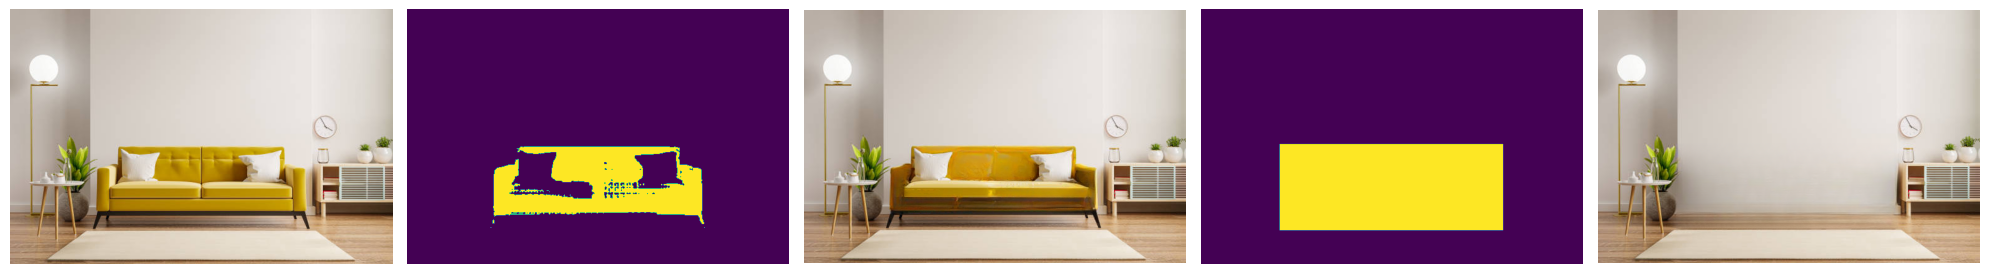

In [64]:
IMAGE_PATH = "input/image2.png"
OUTPUT_SAM_MASK = "output/image2_sam_mask.png"
OUTPUT_GD_MASK = "output/image2_gd_mask.png"
OUTPUT_GD_EXTENDED_MASK = "output/image2_gd_extended_mask.png"

OUTPUT_SAM_SIMPLE_LAMA = "output/image2_sam_simple_lama.png"
OUTPUT_GD_SIMPLE_LAMA = "output/image2_gd_simple_lama.png"
OUTPUT_GD_EXTENDED_SIMPLE_LAMA = "output/image2_gd_extended_simple_lama.png"

bounding_boxes = get_bounding_box(IMAGE_PATH, "sofa")
print(bounding_boxes)
generate_regular_mask(IMAGE_PATH, OUTPUT_GD_MASK, bounding_boxes)
generate_sam_mask(IMAGE_PATH, OUTPUT_SAM_MASK, bounding_boxes)
generate_regular_extended_mask(IMAGE_PATH, OUTPUT_GD_EXTENDED_MASK, bounding_boxes)

inpaint_simplelama(IMAGE_PATH, OUTPUT_SAM_SIMPLE_LAMA, OUTPUT_SAM_MASK)
inpaint_simplelama(IMAGE_PATH, OUTPUT_GD_SIMPLE_LAMA, OUTPUT_GD_MASK)
inpaint_simplelama(IMAGE_PATH, OUTPUT_GD_EXTENDED_SIMPLE_LAMA, OUTPUT_GD_EXTENDED_MASK)

images_to_plot = [
    IMAGE_PATH,
    OUTPUT_SAM_MASK,
    OUTPUT_SAM_SIMPLE_LAMA,
    #OUTPUT_GD_MASK,
    #OUTPUT_GD_SIMPLE_LAMA,
    OUTPUT_GD_EXTENDED_MASK,
    OUTPUT_GD_EXTENDED_SIMPLE_LAMA
]
plot_images(images_to_plot)

## Using Stable diffusion for inpainting
https://huggingface.co/docs/diffusers/en/api/pipelines/stable_diffusion/inpaint

In [65]:
import PIL
import requests
import torch
from io import BytesIO

from diffusers import StableDiffusionInpaintPipeline

IMAGE_PATH = "input/image2.png"
OUTPUT_SAM_MASK = "output/image2_sam_mask.png"
OUTPUT_GD_MASK = "output/image2_gd_mask.png"
OUTPUT_SAM_SIMPLE_LAMA = "output/image2_sam_simple_lama.png"
OUTPUT_GD_SIMPLE_LAMA = "output/image2_gd_simple_lama.png"

IMAGE_PATH_512 = "input/image2_512.png"
OUTPUT_SAM_MASK_512 = "output/image2_sam_mask_512.png"
OUTPUT_GD_MASK_512 = "output/image2_gd_mask_512.png"
OUTPUT_SAM_STABLE_DIFF = "output/image2_sam_sd.png"
OUTPUT_GD_STABLE_DIFF = "output/image2_gd_sd.png"

def resize_image_512(source_image_path, resized_image_path):
    from PIL import Image
    # Load the image
    image = Image.open(source_image_path)
    # Resize the image to 512x512
    resized_image = image.resize((512, 512))
    # Save or display the resized image
    resized_image.save(resized_image_path)  # Save resized image
    return resized_image

# SAM 
init_image = resize_image_512(IMAGE_PATH, IMAGE_PATH_512)
mask_image = resize_image_512(OUTPUT_SAM_MASK, OUTPUT_SAM_MASK_512)
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting", torch_dtype=torch.float16
)
pipe = pipe.to("cuda")
prompt = "Remove the object"

image = pipe(prompt=prompt, image=init_image, mask_image=mask_image).images[0]
image.save(OUTPUT_SAM_STABLE_DIFF)  # Save resized image

# GD 
init_image = resize_image_512(IMAGE_PATH, IMAGE_PATH_512)
mask_image = resize_image_512(OUTPUT_GD_MASK, OUTPUT_GD_MASK_512)
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting", torch_dtype=torch.float16
)
pipe = pipe.to("cuda")
image = pipe(prompt=prompt, image=init_image, mask_image=mask_image).images[0]
image.save(OUTPUT_GD_STABLE_DIFF)  # Save resized image


Loading pipeline components...:  29%|███████████▍                            | 2/7 [00:00<00:01,  3.90it/s]An error occurred while trying to fetch /home/nvidia/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /home/nvidia/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Loading pipeline components...:  57%|██████████████████████▊                 | 4/7 [00:00<00:00,  4.91it/s]An error occurred while trying to fetch /home/nvidia/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /home/nvidia/.cache/huggingface/hub/models--runwayml